# HR Employee Attrition – Análisis y Modelo de Clasificación

## Introducción
La rotación de personal (*attrition*) impacta en costos de reclutamiento, pérdida de conocimiento y productividad. Este proyecto busca **entender los factores asociados a la renuncia** y **construir un modelo que estime la probabilidad de attrition** a nivel individuo.

**Dataset:** `data/HR-Employee-Attrition.csv` (IBM HR Analytics – datos sintéticos para uso educativo, ~1.470 filas y ~35 columnas con variables demográficas, de satisfacción, desempeño y antigüedad).

## Preguntas guía
- ¿Qué variables se asocian más con el attrition? (ej.: `OverTime`, `MonthlyIncome`, `YearsAtCompany`, `JobRole`)
- ¿Existen segmentos con mayor riesgo? (combinaciones de satisfacción, viaje, antigüedad)
- ¿Podemos predecir la renuncia con un desempeño útil para negocio?

## Objetivos
**Analíticos (EDA):**
- Explorar distribución de variables, valores faltantes y outliers.
- Detectar relaciones (bivariadas/multivariadas) relevantes con `Attrition`.

**Modelado (ML):**
- Entrenar un **árbol de decisión** como baseline y comparar con **Random Forest** y **Regresión Logística**.
- Abordar **desbalanceo de clases** (p.ej., `class_weight` o `SMOTE`).
- Evaluar con **ROC-AUC**, **Recall** y **F1** de la clase *Attrition = Yes*.

**Interpretabilidad:**
- Importancia de variables del modelo y, opcionalmente, **SHAP** para explicar predicciones.

## Alcance y supuestos
- Datos sintéticos, útiles para aprendizaje y demostración en portfolio.
- No se incluyen datos personales reales ni información sensible.

## Reproducibilidad
- Requisitos en `requirements.txt`.
- Dataset público incluido en `data/HR-Employee-Attrition.csv`.
- Semillas aleatorias fijadas cuando corresponda.

---

**Estructura del notebook (iterativa):**  
1) EDA → 2) Preprocesamiento → 3) Modelos → 4) Métricas → 5) Interpretabilidad → 6) Conclusiones.

# Configuración inicial

En esta sección se importan las librerías necesarias y se definen configuraciones visuales globales  
que se aplicarán a lo largo del notebook.

In [44]:
# --- Importaciones principales ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [45]:
# --- Configuración visual ---
plt.style.use('seaborn-v0_8')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)

# 1. Carga e inspección inicial de los datos
En esta sección se importa el dataset y se realiza una primera exploración general.  
El objetivo es verificar la estructura, tipos de datos, valores nulos o duplicados,  
y obtener una visión preliminar del contenido antes del análisis detallado.

In [3]:
# --- Carga de datos ---
df = pd.read_csv("data/HR_Employee_Attrition.csv")

In [4]:
# --- Vista general y estructura ---
df.head()
print("\nDimensiones:", df.shape)
df.info()


Dimensiones: (1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14 

In [5]:
# --- Vista general y estructura ---
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [6]:
print("\nDimensiones:", df.shape)
df.info()


Dimensiones: (1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14 

In [7]:
# --- Calidad de datos ---
nulos = df.isnull().sum().sort_values(ascending=False)
print("Valores nulos por columna:\n")
print(nulos.to_string())

duplicados = df.duplicated().sum()
print(f"\nFilas duplicadas: {duplicados}")

Valores nulos por columna:

Age                         0
StandardHours               0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
MonthlyIncome               0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
MonthlyRate                 0
MaritalStatus               0
Attrition                   0
EmployeeCount               0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
JobSatisfaction             0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel    

In [8]:
# --- Estadísticas generales ---
df.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [9]:
# --- Variable objetivo y cardinalidad ---
print("\nDistribución de 'Attrition':")
print(df['Attrition'].value_counts())

print("\nCantidad de valores únicos por columna:")
print(df.nunique().sort_values(ascending=False))


Distribución de 'Attrition':
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Cantidad de valores únicos por columna:
EmployeeNumber              1470
MonthlyRate                 1427
MonthlyIncome               1349
DailyRate                    886
HourlyRate                    71
Age                           43
TotalWorkingYears             40
YearsAtCompany                37
DistanceFromHome              29
YearsInCurrentRole            19
YearsWithCurrManager          18
YearsSinceLastPromotion       16
PercentSalaryHike             15
NumCompaniesWorked            10
JobRole                        9
TrainingTimesLastYear          7
EducationField                 6
JobLevel                       5
Education                      5
StockOptionLevel               4
JobInvolvement                 4
JobSatisfaction                4
WorkLifeBalance                4
EnvironmentSatisfaction        4
RelationshipSatisfaction       4
BusinessTravel                 3
Department 

## Eliminación de variables sin valor explicativo

Antes del análisis exploratorio y posterior modelado, se eliminan las variables que no aportan información relevante para predecir la variable objetivo `Attrition`.  
A partir del análisis de la cantidad de valores únicos por columna, se observa que algunas variables son constantes o identificadoras, por lo que carecen de valor predictivo.

Las variables eliminadas son:

- **EmployeeNumber:** identificador único de cada empleado (sin relación con la rotación).  
- **EmployeeCount:** solo un valor único en toda la columna.  
- **StandardHours:** constante para todos los registros.  
- **Over18:** también constante, dado que todos los empleados son mayores de edad.  

Estas variables no tienen potencial explicativo y se eliminan del dataset antes del modelado.

In [10]:
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18']
df = df.drop(columns=cols_to_drop)

In [11]:
# Verificación rápida tras la eliminación
print("Dimensiones después de eliminar columnas:", df.shape)

Dimensiones después de eliminar columnas: (1470, 31)


# 2. Preparación y transformación de variables
En esta sección se realiza el preprocesamiento inicial del dataset.  
Se revisa la variable objetivo **Attrition** y se la convierte a formato numérico (1 = Yes, 0 = No),  
dejando el conjunto de datos listo para el análisis exploratorio y el modelado posterior.

## Transformación de variables dicotómicas

En esta etapa se convierten las variables categóricas binarias (con valores `Yes/No` o `Male/Female`) 
a formato numérico (`1/0`), requisito necesario para los algoritmos de *Machine Learning*.  
La variable objetivo **Attrition** (renuncia del empleado) y las variables **OverTime** y **Gender**
se transforman en valores binarios equivalentes.

In [12]:
# --- Verificación de la variable objetivo ---
df['Attrition'].unique()

array(['Yes', 'No'], dtype=object)

In [13]:
# --- Transformación de variables dicotómicas ---
# Se convierten las variables categóricas binarias (Yes/No) a formato numérico (1/0)
df['Attrition'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df['OverTime'] = df['OverTime'].apply(lambda x: 1 if x == 'Yes' else 0)
df['Gender'] = df['Gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [14]:
# Verificación del cambio
print("Attrition:")
print(df['Attrition'].value_counts(), "\n")
print("OverTime:")
print(df['OverTime'].value_counts(), "\n")
print("Gender:")
print(df['Gender'].value_counts())

Attrition:
Attrition
0    1233
1     237
Name: count, dtype: int64 

OverTime:
OverTime
0    1054
1     416
Name: count, dtype: int64 

Gender:
Gender
1    882
0    588
Name: count, dtype: int64


## Análisis del balance de clases

Antes del modelado, es importante observar la proporción de empleados que renunciaron (`Attrition = 1`)  
respecto de los que permanecen en la empresa (`Attrition = 0`). Esto permite anticipar posibles sesgos del modelo.

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\2613174269.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Attrition', data=df, palette='Set2')


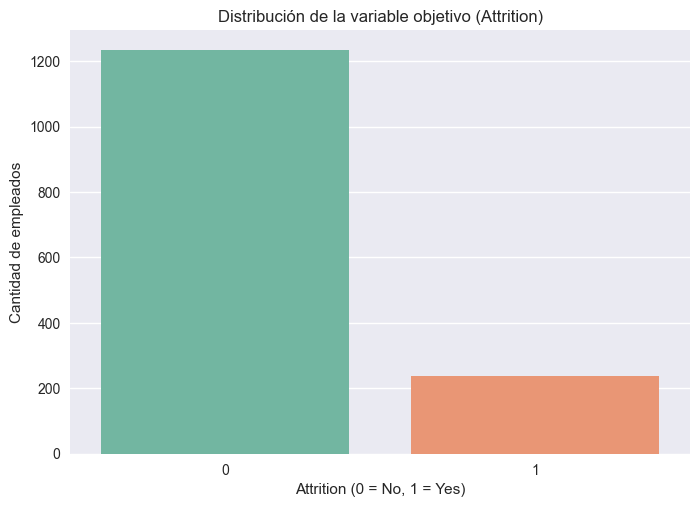

Procentaje de cada clase: Attrition
0    83.88
1    16.12
Name: proportion, dtype: float64


In [15]:
# --- Análisis del balance de clases ---
sns.countplot(x='Attrition', data=df, palette='Set2')
plt.title('Distribución de la variable objetivo (Attrition)')
plt.xlabel('Attrition (0 = No, 1 = Yes)')
plt.ylabel('Cantidad de empleados')
plt.show()

# Porcentaje de cada clase
attrition_rate = df['Attrition'].value_counts(normalize=True) * 100
print(f"Procentaje de cada clase: {attrition_rate.round(2)}")

## Identificación de variables numéricas y categóricas

Antes de avanzar con el análisis exploratorio, se identifican las variables numéricas y categóricas del dataset.  
Esto permitirá decidir qué tipo de visualizaciones y transformaciones aplicar en cada caso.

In [16]:
# --- Identificación de variables numéricas y categóricas ---

# Seleccionamos los nombres de las columnas según su tipo
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print("Variables numéricas:", len(num_cols))
print(num_cols.tolist())
print("\nVariables categóricas:", len(cat_cols))
print(cat_cols.tolist())

Variables numéricas: 26
['Age', 'Attrition', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

Variables categóricas: 5
['BusinessTravel', 'Department', 'EducationField', 'JobRole', 'MaritalStatus']


## Codificación de variables categóricas (One-Hot Encoding)

Algunas variables categóricas contienen más de dos categorías (por ejemplo, 
`BusinessTravel`, `Department`, `JobRole`, `MaritalStatus` o `EducationField`).  
Para que puedan ser utilizadas por los algoritmos de *Machine Learning*, se transforman 
mediante **One-Hot Encoding**, que crea una nueva columna por cada categoría posible, 
con valores binarios (`0` o `1`).  

Este paso convierte todas las variables categóricas en formato numérico, 
manteniendo la información original sin introducir un orden artificial entre las categorías.

In [17]:
# Selección de variables categóricas a codificar
X_cat = df[['BusinessTravel', 'EducationField', 'Department', 'JobRole', 'MaritalStatus']]

In [18]:
# Inicialización y transformación
ohe = OneHotEncoder()
X_cat_encoded = ohe.fit_transform(X_cat).toarray()

In [19]:
# Conversión a DataFrame con nombres de columnas legibles
X_cat_encoded = pd.DataFrame(
    X_cat_encoded, 
    columns=ohe.get_feature_names_out(X_cat.columns)
)

In [20]:
# Se conserva el mismo índice del DataFrame original
# para mantener alineadas las filas al concatenar.
X_cat_encoded.index = df.index

In [21]:
# --- Unión con el DataFrame original y eliminación de las columnas originales ---
df_encoded = pd.concat([df.drop(X_cat.columns, axis=1), X_cat_encoded], axis=1)

In [22]:
# Verificación final
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                1470 non-null   int64  
 1   Attrition                          1470 non-null   int64  
 2   DailyRate                          1470 non-null   int64  
 3   DistanceFromHome                   1470 non-null   int64  
 4   Education                          1470 non-null   int64  
 5   EnvironmentSatisfaction            1470 non-null   int64  
 6   Gender                             1470 non-null   int64  
 7   HourlyRate                         1470 non-null   int64  
 8   JobInvolvement                     1470 non-null   int64  
 9   JobLevel                           1470 non-null   int64  
 10  JobSatisfaction                    1470 non-null   int64  
 11  MonthlyIncome                      1470 non-null   int64

# 3. Análisis exploratorio de los datos (EDA)

En esta sección se analizan distribuciones, relaciones y patrones entre variables 
(numéricas y categóricas) con foco en su vínculo con **Attrition**.

## Correlación de las variables numéricas con Attrition

La correlación de las variables numéricas con la variable objetivo es baja en general,  
lo que sugiere que la rotación no depende de un solo factor cuantitativo,  
sino de la combinación de múltiples variables (numéricas y categóricas).

Attrition                   1.000000
OverTime                    0.246118
DistanceFromHome            0.077924
NumCompaniesWorked          0.043494
Gender                      0.029453
MonthlyRate                 0.015170
PerformanceRating           0.002889
HourlyRate                 -0.006846
PercentSalaryHike          -0.013478
Education                  -0.031373
YearsSinceLastPromotion    -0.033019
RelationshipSatisfaction   -0.045872
DailyRate                  -0.056652
TrainingTimesLastYear      -0.059478
WorkLifeBalance            -0.063939
EnvironmentSatisfaction    -0.103369
JobSatisfaction            -0.103481
JobInvolvement             -0.130016
YearsAtCompany             -0.134392
StockOptionLevel           -0.137145
YearsWithCurrManager       -0.156199
Age                        -0.159205
MonthlyIncome              -0.159840
YearsInCurrentRole         -0.160545
JobLevel                   -0.169105
TotalWorkingYears          -0.171063
Name: Attrition, dtype: float64


C:\Users\elias\AppData\Local\Temp\ipykernel_22276\999904047.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')


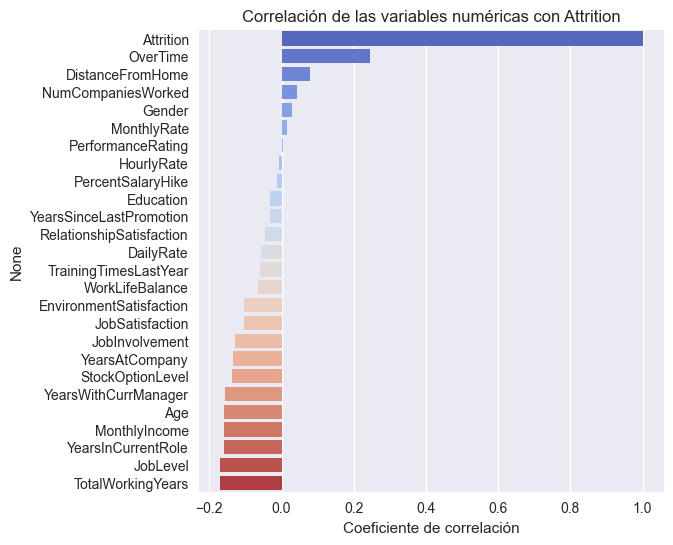

In [23]:
# --- Correlación de variables numéricas con Attrition ---
corr_target = df.corr(numeric_only=True)['Attrition'].sort_values(ascending=False)
print(corr_target)

# Visualización más clara
plt.figure(figsize=(6,6))
sns.barplot(x=corr_target.values, y=corr_target.index, palette='coolwarm')
plt.title('Correlación de las variables numéricas con Attrition')
plt.xlabel('Coeficiente de correlación')
plt.show()

Para mejorar la legibilidad, se seleccionaron las variables numéricas más relevantes en lugar de mostrar la matriz completa de correlaciones.  
Estas variables reflejan distintos aspectos del perfil laboral (edad, ingreso, antigüedad, promociones, distancia al trabajo) que podrían influir en la rotación del personal.

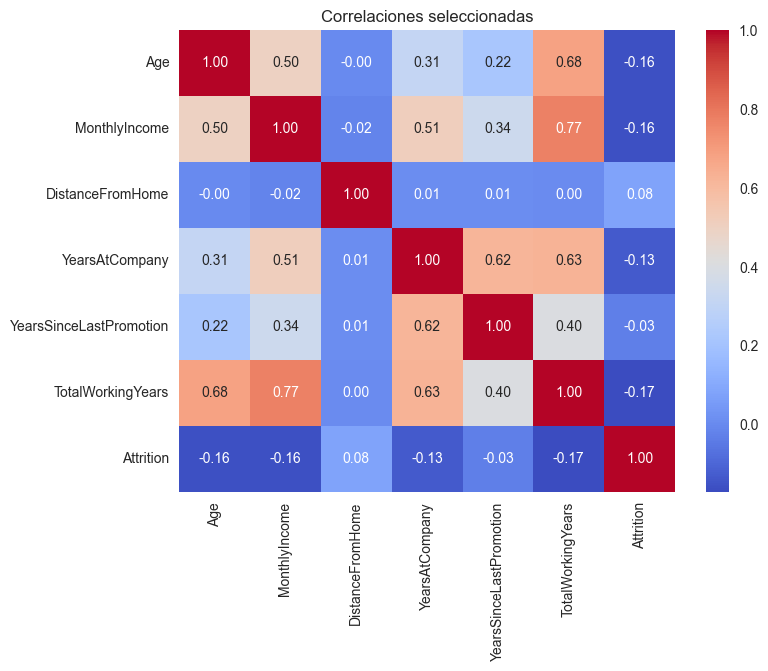

In [24]:
# --- Matriz de correlación de variables numéricas seleccionadas ---
num_focus = ['Age', 'MonthlyIncome', 'DistanceFromHome', 'YearsAtCompany',
             'YearsSinceLastPromotion', 'TotalWorkingYears', 'Attrition']

plt.figure(figsize=(8,6))
sns.heatmap(df[num_focus].corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlaciones seleccionadas')
plt.show()

## Análisis de variables categóricas
En esta sección se exploran las principales variables categóricas en relación con la variable objetivo **Attrition**, 
para detectar patrones de comportamiento o posibles factores asociados a la rotación del personal.

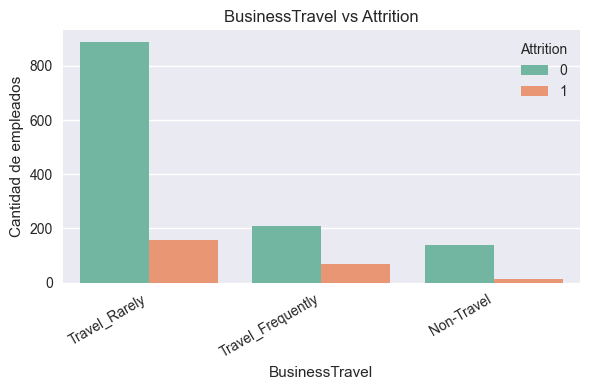

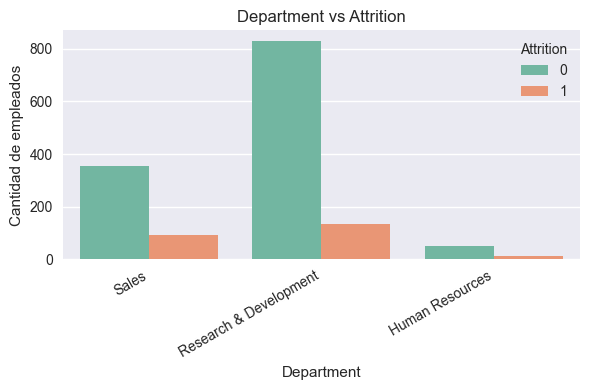

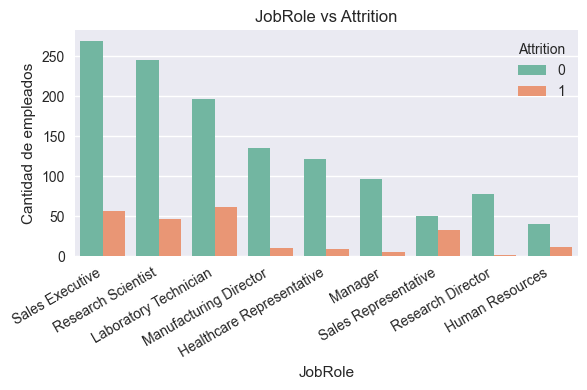

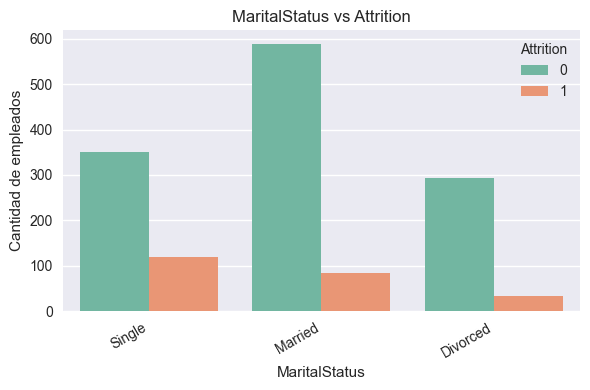

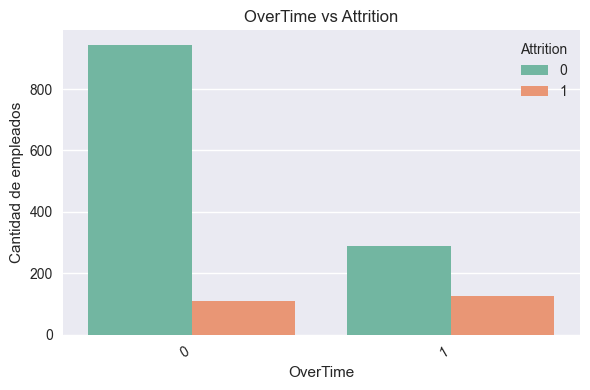

In [25]:
# --- Variables categóricas clave ---
cat_focus = ['BusinessTravel', 'Department', 'JobRole', 'MaritalStatus', 'OverTime']

for col in cat_focus:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Attrition', data=df, palette='Set2')
    plt.title(f'{col} vs Attrition')
    plt.xlabel(col)
    plt.ylabel('Cantidad de empleados')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

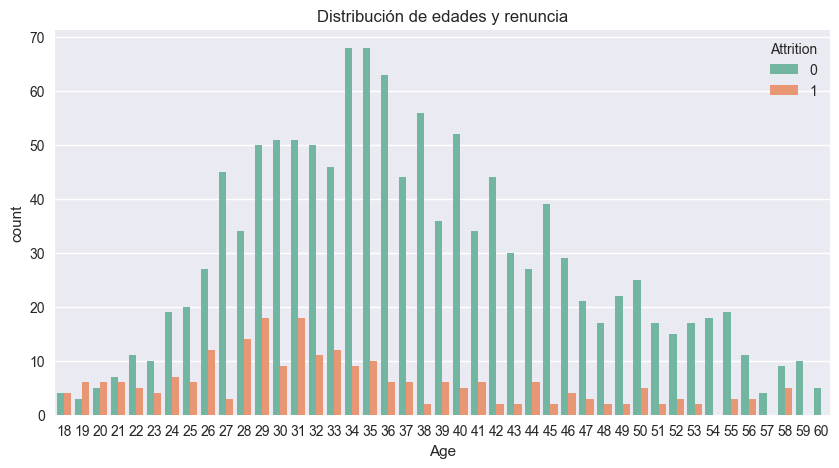

In [26]:
# Edad vs renuncia
plt.figure(figsize=(10,5))
sns.countplot(x='Age', hue='Attrition', data=df, palette='Set2')
plt.title('Distribución de edades y renuncia')
plt.show()

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\1014307668.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Attrition']==1]['DistanceFromHome'], label="Renuncian", color='r', shade=True)
C:\Users\elias\AppData\Local\Temp\ipykernel_22276\1014307668.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['Attrition']==0]['DistanceFromHome'], label="Permanecen", color='b', shade=True)


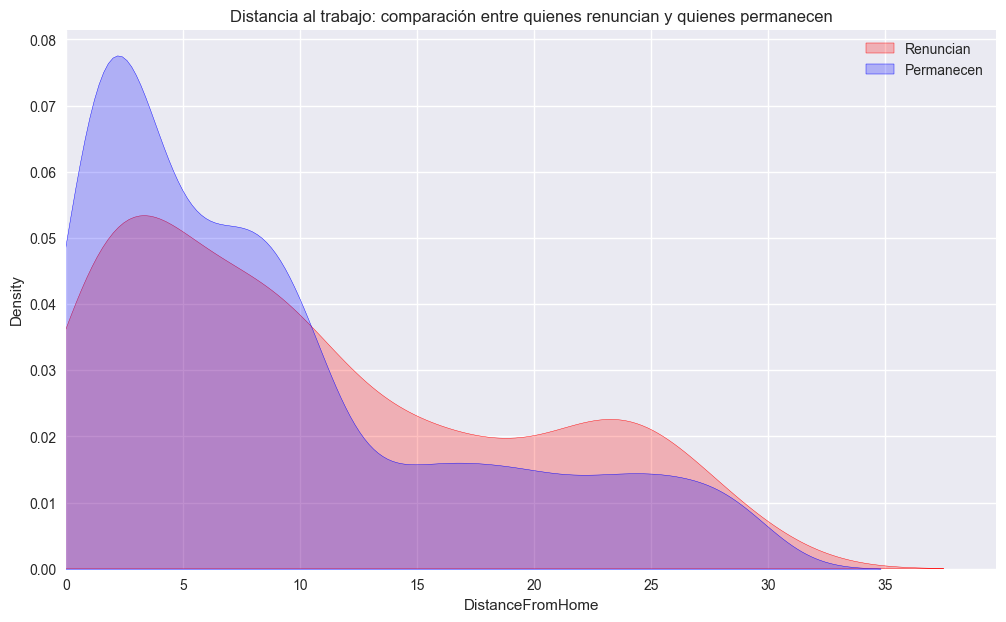

In [27]:
plt.figure(figsize=(12,7))
sns.kdeplot(df[df['Attrition']==1]['DistanceFromHome'], label="Renuncian", color='r', shade=True)
sns.kdeplot(df[df['Attrition']==0]['DistanceFromHome'], label="Permanecen", color='b', shade=True)
plt.title('Distancia al trabajo: comparación entre quienes renuncian y quienes permanecen')
plt.xlabel('DistanceFromHome')
plt.legend()
plt.xlim(0)
plt.show()

### Interpretación general de las variables

Se observan patrones claros en la relación entre las variables y la variable objetivo (**Attrition**),  
que representa la **renuncia del empleado** a la empresa:

- Los empleados que realizan **horas extra (`OverTime = Yes`)** presentan una tasa de **renuncia** significativamente mayor.  
- En cuanto a los **roles y departamentos**, se observa una mayor proporción de **renuncias** en ciertos puestos específicos, especialmente entre *Sales Executive*, *Laboratory Technician* y *Research Scientist*.  
  Esto sugiere que las funciones más operativas o de base presentan un **mayor nivel de abandono** que los cargos gerenciales.  
- El **estado civil** también muestra diferencias: los empleados **solteros** tienden a **renunciar** más que los casados o divorciados.  
- En relación con los **viajes laborales (`BusinessTravel`)**, quienes viajan con mayor frecuencia exhiben una **ligera tendencia** a dejar la empresa.  
- En las variables numéricas, los empleados **más jóvenes** presentan mayores tasas de renuncia, lo que podría asociarse a una menor estabilidad laboral o búsqueda de nuevas oportunidades.  
- La **distancia desde el hogar (`DistanceFromHome`)** muestra una leve diferencia: quienes viven más lejos tienden a **renunciar algo más**, aunque el efecto no es determinante.

Estos resultados indican que la **renuncia** de los empleados no depende de un único factor cuantitativo,  
sino de la **combinación de condiciones laborales y personales**, que en conjunto pueden aumentar la probabilidad de abandono.

## Síntesis del análisis exploratorio

El análisis exploratorio permitió identificar patrones tanto en variables numéricas como categóricas.  
Las correlaciones mostraron relaciones débiles entre las variables cuantitativas y la renuncia, lo que sugiere que el abandono de la empresa 
no depende de un único factor medible, sino de la combinación de aspectos laborales y personales.  
En las variables categóricas, destacan las tasas más altas de renuncia entre empleados con horas extra frecuentes, 
determinados puestos operativos y personas solteras.  
Estos hallazgos orientan las siguientes etapas de modelado predictivo, 
donde se evaluará qué variables contribuyen con mayor peso a predecir la probabilidad de renuncia.

# 4. Modelado predictivo

En esta etapa se construyen y evalúan distintos modelos de *Machine Learning* con el objetivo de 
**predecir la probabilidad de renuncia de un empleado** a partir de las variables disponibles.  

Se compararán varios enfoques de clasificación, comenzando con un **Árbol de Decisión**, 
seguido por un **Bosque Aleatorio (Random Forest)** y una **Regresión Logística**.  
Estos modelos permitirán analizar tanto el rendimiento predictivo como la importancia relativa de las variables.  

Antes del entrenamiento, se definen las variables predictoras (**X**) y la variable objetivo (**y**), 
y se realiza la **división del conjunto de datos** en entrenamiento y prueba, 
manteniendo la proporción de clases observada en el dataset original (*stratify*).

In [28]:
# --- Definición de variables predictoras y variable objetivo ---
X = df_encoded.drop('Attrition', axis=1)
y = df_encoded['Attrition']

In [29]:
# --- División en conjunto de entrenamiento y prueba ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [30]:
print(f"Tamaño de entrenamiento: {len(X_train)}")
print(f"Tamaño de prueba: {len(X_test)}")

Tamaño de entrenamiento: 1029
Tamaño de prueba: 441


## 4.1 Árbol de Decisión (Decision Tree)

El **Árbol de Decisión** es un modelo de *Machine Learning* supervisado que divide el conjunto de datos en ramas basadas en reglas de decisión simples.  
Cada división busca maximizar la pureza de las clases mediante métricas como la *entropía* o el *índice Gini*, permitiendo identificar patrones de decisión fácilmente interpretables.  

En este caso, el modelo se utiliza para **predecir la renuncia de empleados** (*Attrition*), considerando que el dataset presenta un **fuerte desbalance de clases** (menos del 20 % de renuncias).  
Por ello, se comparan dos enfoques:

1. **Modelo sin balancear:** entrena el árbol con los datos tal como están, lo que suele favorecer a la clase mayoritaria.  
2. **Modelo balanceado:** utiliza el parámetro `class_weight='balanced'` para ajustar los pesos de las clases y darle mayor relevancia a los casos minoritarios (empleados que renuncian).  

Ambos modelos se entrenan y evalúan bajo las mismas condiciones, utilizando un 70 % de los datos para entrenamiento y un 30 % para prueba.  
Esta comparación permite analizar si el balanceo de clases mejora la capacidad del modelo para detectar renuncias sin sacrificar la precisión global.

In [31]:
# --- Modelo base (sin balancear) ---
# Se entrena un Árbol de Decisión estándar, sin ajuste de pesos entre clases.
model_dt_unbalanced = DecisionTreeClassifier(random_state=42)
model_dt_unbalanced.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:
# --- Modelo balanceado ---
# Se aplica class_weight='balanced' para dar mayor peso a la clase minoritaria (renuncias).
model_dt_balanced = DecisionTreeClassifier(random_state=42, class_weight='balanced')
model_dt_balanced.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [33]:
# --- Predicciones ---
# Se generan las predicciones sobre el conjunto de prueba (X_test) para ambos modelos.
y_pred_dt_unbalanced = model_dt_unbalanced.predict(X_test)
y_pred_dt_balanced = model_dt_balanced.predict(X_test)

=== Modelo sin balancear ===
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       370
           1       0.29      0.34      0.31        71

    accuracy                           0.76       441
   macro avg       0.58      0.59      0.58       441
weighted avg       0.77      0.76      0.77       441


=== Modelo balanceado ===
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       370
           1       0.28      0.28      0.28        71

    accuracy                           0.77       441
   macro avg       0.57      0.57      0.57       441
weighted avg       0.77      0.77      0.77       441



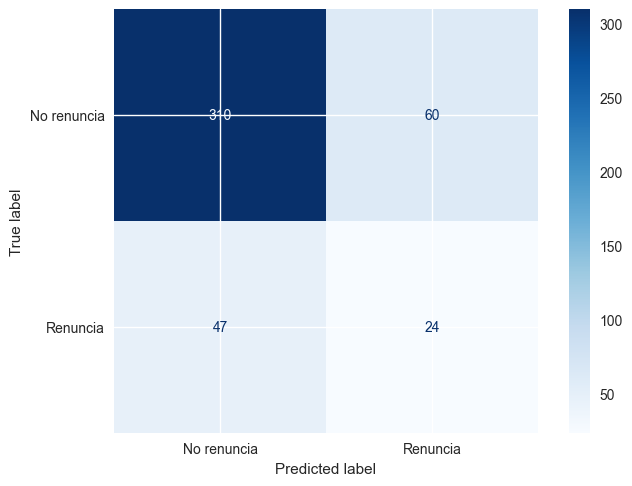

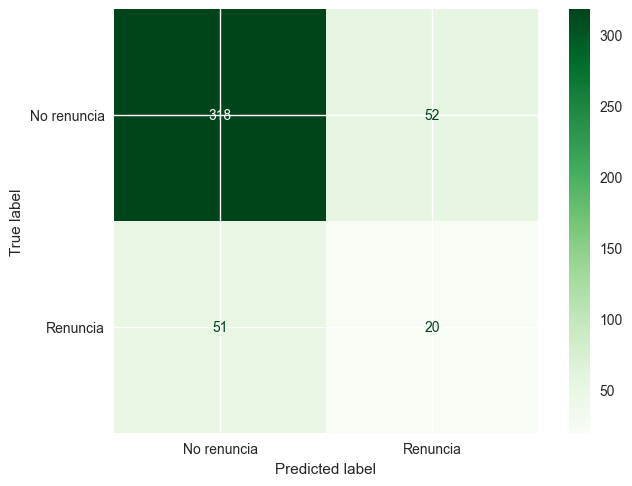

In [34]:
# --- Evaluación del modelo Árbol de Decisión (Decision Tree) ---

print("=== Modelo sin balancear ===")
print(classification_report(y_test, y_pred_dt_unbalanced))
cm_dt_unbalanced = confusion_matrix(y_test, y_pred_dt_unbalanced)
ConfusionMatrixDisplay(cm_dt_unbalanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Blues')

print("\n=== Modelo balanceado ===")
print(classification_report(y_test, y_pred_dt_balanced))
cm_dt_balanced = confusion_matrix(y_test, y_pred_dt_balanced)
ConfusionMatrixDisplay(cm_dt_balanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Greens')

### Visualización simplificada del Árbol de Decisión
Se muestra un árbol reducido (profundidad limitada) con fines ilustrativos, para comprender cómo el modelo toma decisiones iniciales.

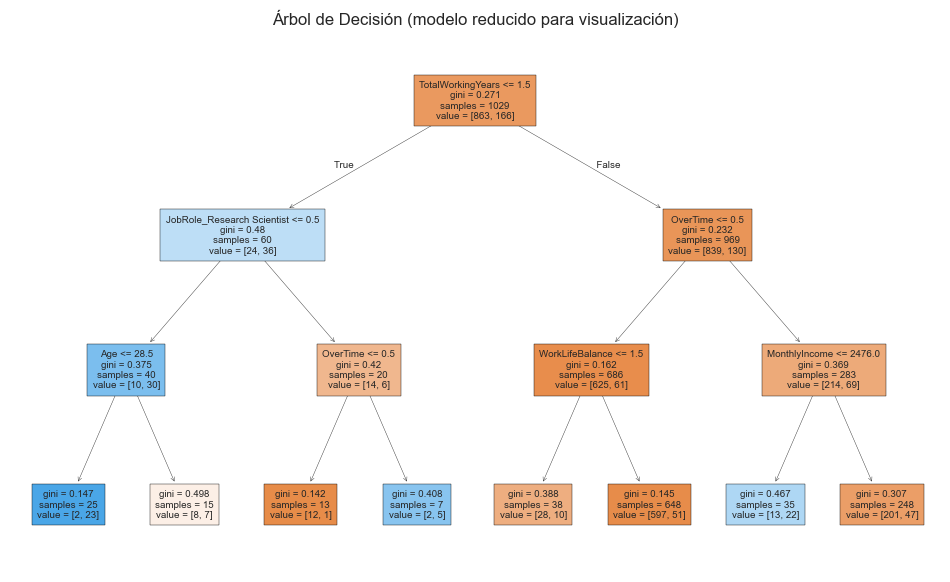

In [35]:
# --- Visualización simplificada del Árbol de Decisión ---
# Árbol reducido (profundidad limitada) para fines ilustrativos
vis_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
vis_tree.fit(X_train, y_train)

plt.figure(figsize=(12, 7))
plot_tree(vis_tree, feature_names=X.columns, filled=True, fontsize=7)
plt.title("Árbol de Decisión (modelo reducido para visualización)")
plt.show()

### Importancia de las variables en el Árbol de Decisión
Además de la visualización estructural del árbol, es útil analizar la **importancia de las variables**,  
que muestra qué atributos tienen mayor peso en la predicción de la renuncia de empleados.

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\1418940434.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_dt[indices_dt][:10], y=X.columns[indices_dt][:10], palette='Set2')


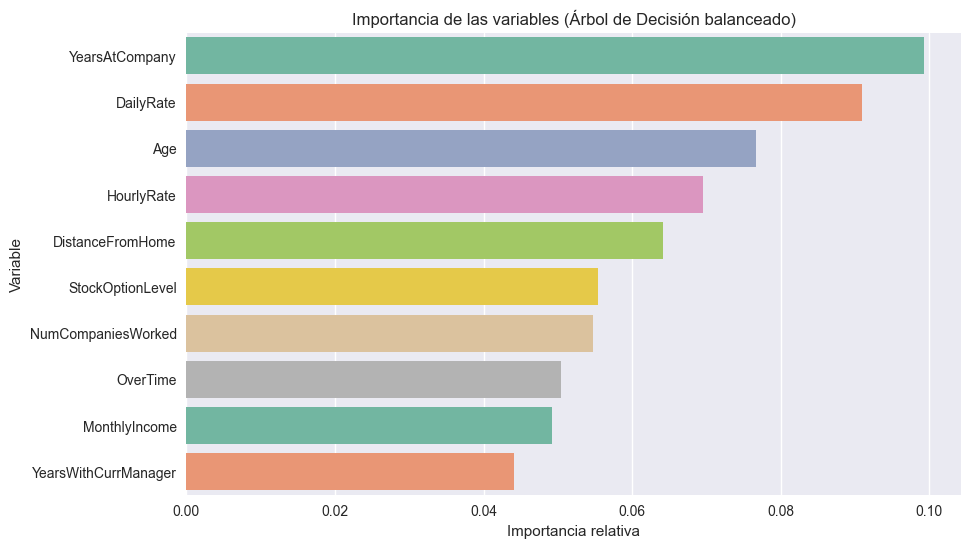

In [36]:
# --- Importancia de las variables en el Árbol de Decisión ---

importances_dt = model_dt_balanced.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances_dt[indices_dt][:10], y=X.columns[indices_dt][:10], palette='Set2')
plt.title("Importancia de las variables (Árbol de Decisión balanceado)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

### 📊 Interpretación del modelo de Árbol de Decisión

El **Árbol de Decisión** presenta un rendimiento global aceptable, con una **precisión general (accuracy)** cercana al **76–77 %** tanto en la versión sin balancear como en la versión balanceada.  

Sin embargo, al analizar el desempeño por clase, se observa una marcada asimetría:

- Para la clase **0 (No renuncia)**, el modelo muestra valores altos de *precision* y *recall* (≈ 0.85), lo que indica que identifica correctamente la mayoría de los empleados que permanecen en la empresa.  
- En cambio, para la clase **1 (Renuncia)**, las métricas de *precision* y *recall* son sensiblemente menores (≈ 0.28–0.34), reflejando la **dificultad del modelo para detectar casos de renuncia**.  
  Este comportamiento responde al **desbalance de clases** del dataset, donde las renuncias representan menos del 20 % de los casos totales.

El ajuste mediante `class_weight='balanced'` **no mejora sustancialmente el rendimiento global**, aunque contribuye a distribuir mejor la penalización de errores entre clases. En este caso, la precisión total se mantiene constante, pero el modelo balanceado tiende a ser ligeramente más equitativo en la ponderación de errores.

---

### 🔍 Análisis de variables más relevantes

El análisis de **importancia de las variables** muestra que los factores con mayor peso en las decisiones del modelo son principalmente **características laborales cuantitativas**:

- **YearsAtCompany**, **DailyRate** y **Age** se destacan como las variables más influyentes, seguidas por **HourlyRate**, **DistanceFromHome** y **StockOptionLevel**.  
- Este patrón sugiere que la **antigüedad** y ciertos **indicadores salariales** son los elementos más considerados por el modelo al predecir la probabilidad de renuncia.  
- Factores personales como el **OverTime** o la **cantidad de empresas previas (NumCompaniesWorked)** también muestran una incidencia moderada, lo que podría reflejar trayectorias laborales más inestables.

---

**Conclusión:**  
El Árbol de Decisión permite una **primera aproximación interpretativa clara** y un rendimiento razonable, pero su capacidad predictiva sobre los empleados que efectivamente renuncian sigue siendo limitada.  
Dado este resultado, el siguiente paso consiste en evaluar **modelos más robustos y generalizables**, como el **Bosque Aleatorio** y la **Regresión Logística**, con el objetivo de **mejorar la sensibilidad del modelo frente a la clase minoritaria** sin sacrificar la precisión global.

## 4.2 Bosque Aleatorio (Random Forest)

El **Bosque Aleatorio** es un modelo de *Machine Learning* supervisado basado en el principio del *ensemble learning*.  
Combina múltiples **árboles de decisión** entrenados sobre diferentes subconjuntos aleatorios de datos y variables (*bagging* y *feature randomness*), con el objetivo de reducir el sobreajuste y mejorar la capacidad de generalización del modelo.  

En este caso, el modelo se aplica para **predecir la renuncia de empleados** (*Attrition*), utilizando los mismos conjuntos de entrenamiento y prueba que en el Árbol de Decisión.  
Al igual que en el caso anterior, el dataset presenta un **fuerte desbalance de clases** (una proporción menor de empleados que renuncian), por lo cual se evalúan dos enfoques:

1. **Modelo sin balancear:** entrena el bosque con los datos originales, lo que tiende a favorecer la clase mayoritaria.  
2. **Modelo balanceado:** aplica el parámetro `class_weight='balanced'`, que ajusta los pesos de las clases de manera inversamente proporcional a su frecuencia, mejorando la detección de la clase minoritaria (renuncias).  

Ambos modelos se entrenan bajo las mismas condiciones y se evalúan mediante métricas de desempeño (*precision*, *recall*, *f1-score* y *accuracy*).  
Finalmente, se analiza la **importancia de las variables** para identificar los factores que más contribuyen a predecir la renuncia de empleados.  

En la siguiente subsección (**4.2.1**), se incorporan **estrategias adicionales de balanceo de clases** para evaluar si estas técnicas pueden mejorar la sensibilidad del modelo frente a los casos de renuncia.

In [37]:
# --- Modelo base (sin balancear) ---
# Se entrena un bosque aleatorio estándar, sin ajuste de pesos entre clases.
# n_estimators: cantidad de árboles (100 por defecto, se explicita por claridad).
# n_jobs=-1: utiliza todos los núcleos disponibles del procesador para acelerar el entrenamiento.
model_rf_unbalanced = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
model_rf_unbalanced.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [38]:
# --- Modelo balanceado ---
# Se aplica class_weight='balanced' para dar mayor peso a la clase minoritaria (renuncias).
# Se mantienen los mismos hiperparámetros para asegurar una comparación justa.
model_rf_balanced = RandomForestClassifier(
    random_state=42,
    n_estimators=100,
    n_jobs=-1,
    class_weight='balanced'
)
model_rf_balanced.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [39]:
# --- Predicciones ---
# Se generan las predicciones sobre el conjunto de prueba (X_test) para ambos modelos.
y_pred_rf_unbalanced = model_rf_unbalanced.predict(X_test)
y_pred_rf_balanced = model_rf_balanced.predict(X_test)

=== Modelo sin balancear ===
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       370
           1       0.42      0.14      0.21        71

    accuracy                           0.83       441
   macro avg       0.64      0.55      0.56       441
weighted avg       0.78      0.83      0.79       441


=== Modelo balanceado ===
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       370
           1       0.54      0.10      0.17        71

    accuracy                           0.84       441
   macro avg       0.69      0.54      0.54       441
weighted avg       0.80      0.84      0.79       441



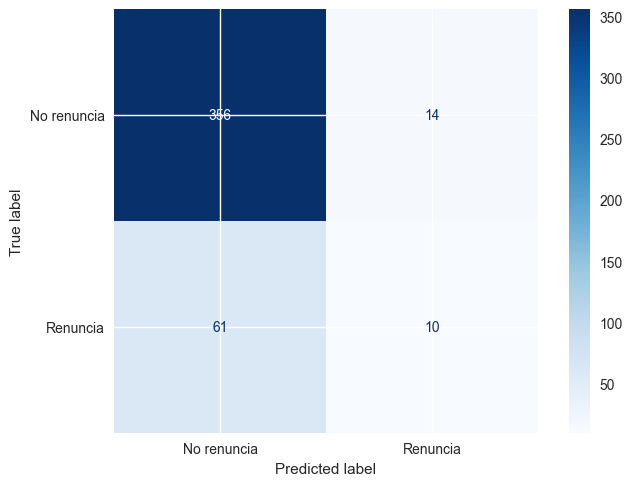

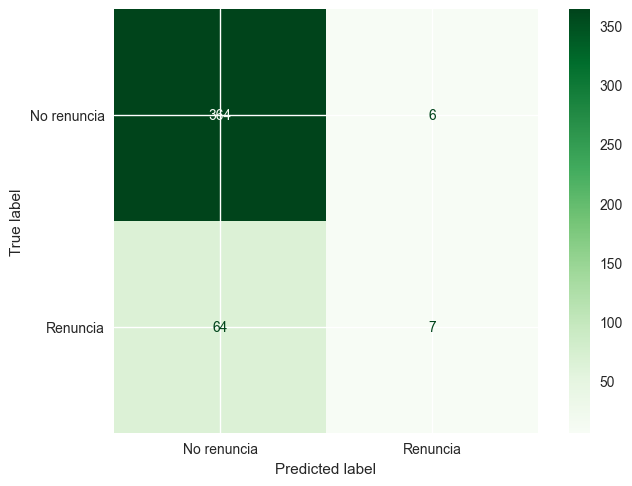

In [40]:
print("=== Modelo sin balancear ===")
print(classification_report(y_test, y_pred_rf_unbalanced))
cm_rf_unbalanced = confusion_matrix(y_test, y_pred_rf_unbalanced)
ConfusionMatrixDisplay(cm_rf_unbalanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Blues')

print("\n=== Modelo balanceado ===")
print(classification_report(y_test, y_pred_rf_balanced))
cm_rf_balanced = confusion_matrix(y_test, y_pred_rf_balanced)
ConfusionMatrixDisplay(cm_rf_balanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Greens')


### Importancia de las variables en el Bosque Aleatorio
El Bosque Aleatorio no puede visualizarse como un único árbol, ya que está compuesto por múltiples árboles de decisión.  
En su lugar, se analiza la **importancia de las variables**, que indica el peso relativo de cada atributo en las predicciones del modelo balanceado.

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\1829820720.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette='Set2')


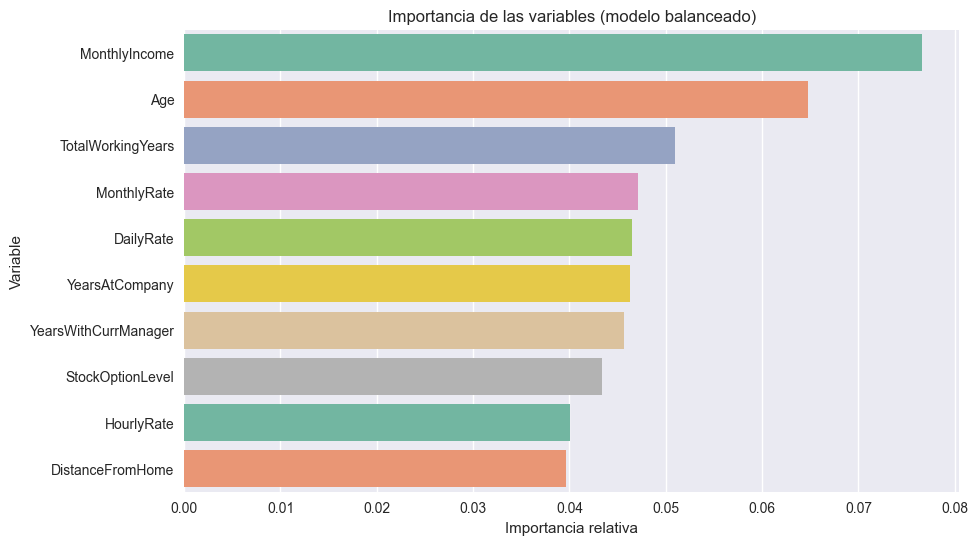

In [41]:
### Importancia de las variables en el Bosque Aleatorio
# Se muestran las variables con mayor peso en la predicción de la renuncia.

importances = model_rf_balanced.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:10], y=X.columns[indices][:10], palette='Set2')
plt.title("Importancia de las variables (modelo balanceado)")
plt.xlabel("Importancia relativa")
plt.ylabel("Variable")
plt.show()

### 📊 Interpretación del modelo de Bosque Aleatorio

El **Bosque Aleatorio** presenta un **rendimiento superior al Árbol de Decisión**, alcanzando una *accuracy* general de **83–84 %** tanto en la versión sin balancear como en la balanceada.  
Su mayor estabilidad y capacidad de generalización se reflejan en el mejor desempeño sobre la clase mayoritaria (*No renuncia*).

- Para la clase **0 (No renuncia)**, el modelo obtiene altos valores de *precision* (≈ 0.85) y *recall* (≈ 0.96–0.98), evidenciando una muy buena capacidad para reconocer correctamente a los empleados que permanecen en la empresa.  
- En contraste, para la clase **1 (Renuncia)**, el desempeño sigue siendo bajo: el *recall* se ubica entre **0.10 y 0.14**, lo que indica que el modelo **detecta pocos casos reales de renuncia**.  
  Aunque el uso de `class_weight='balanced'` incrementa levemente la *precision* (de 0.42 → 0.54), **no logra mejorar el recall**, que incluso disminuye.

En síntesis, el **bosque logra mayor precisión global** y menor sobreajuste que el árbol, pero sigue afectado por el **desbalance de clases**, que limita su sensibilidad frente a las renuncias.

---

### 🔍 Análisis de variables más relevantes

El análisis de **importancia de variables** muestra un patrón coherente con el modelo anterior, aunque con una ponderación más estable:

- **MonthlyIncome**, **Age** y **TotalWorkingYears** son las variables más influyentes en la predicción de la renuncia.  
- Les siguen **MonthlyRate**, **DailyRate** y **YearsAtCompany**, todas relacionadas con factores salariales o de antigüedad.  
- También se destacan **YearsWithCurrManager** y **DistanceFromHome**, que podrían reflejar vínculos con la supervisión o la ubicación geográfica del empleado.

Este resultado sugiere que los **factores económicos y de trayectoria laboral** tienen mayor peso predictivo que los comportamientos individuales (como *OverTime*), al menos en la estructura actual del dataset.

---

**Conclusión:**  
El Bosque Aleatorio ofrece una **mejor capacidad de generalización** que el Árbol de Decisión, con una precisión global más alta y una jerarquía de variables más estable.  
Sin embargo, la **baja sensibilidad para la clase de renuncias** persiste, lo que indica que, aunque el modelo mejora el rendimiento general, **todavía presenta dificultades para identificar correctamente los casos minoritarios**.  
En la siguiente sección, se evalúa un **modelo lineal de Regresión Logística**, con el objetivo de analizar si una estructura más simple y regularizada logra un mejor equilibrio entre precisión y sensibilidad.

## 4.3 Regresión Logística (Logistic Regression)

La **Regresión Logística** es un modelo lineal ampliamente utilizado en problemas de **clasificación binaria**, que estima la probabilidad de que una observación pertenezca a una clase determinada.  
A diferencia de los modelos basados en árboles, la regresión logística **asume una relación lineal entre las variables independientes y el logaritmo de las probabilidades (odds)** de pertenecer a la clase positiva.

En este caso, se aplica para **predecir la probabilidad de renuncia de empleados** (*Attrition*), utilizando el mismo conjunto de entrenamiento y prueba que en los modelos anteriores.  
Su ventaja principal radica en su **interpretabilidad** y en la capacidad para identificar **qué variables influyen de forma positiva o negativa** en la probabilidad de renuncia.

El modelo se entrenará en dos variantes:

1. **Modelo base:** Regresión Logística estándar con regularización L2 (Ridge).  
2. **Modelo balanceado:** uso del parámetro `class_weight='balanced'` para compensar la menor presencia de la clase de renuncias en los datos.

Ambos modelos se evaluarán mediante las mismas métricas (*precision*, *recall*, *f1-score*, *accuracy*), a fin de **comparar su desempeño frente al Árbol de Decisión y al Bosque Aleatorio**.

In [46]:
# --- Modelo base (sin balancear) ---
# Se entrena una regresión logística sin ajuste de pesos entre clases.
model_lg_unbalanced = LogisticRegression(
    max_iter=1000, 
    random_state=42
)
model_lg_unbalanced.fit(X_train, y_train)

c:\Users\elias\anaconda3\envs\ml_attrition_models\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

In [47]:
# --- Modelo balanceado ---
# Se entrena una regresión logística con ajuste de pesos entre clases.
model_lg_balanced = LogisticRegression(
    max_iter=1000, 
    random_state=42, 
    class_weight='balanced'
)
model_lg_balanced.fit(X_train, y_train)

c:\Users\elias\anaconda3\envs\ml_attrition_models\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [48]:
# --- Predicciones ---
# Se generan las predicciones sobre el conjunto de prueba (X_test) para ambos modelos.
y_pred_lg_unbalanced = model_lg_unbalanced.predict(X_test)
y_pred_lg_balanced = model_lg_balanced.predict(X_test)

=== Modelo sin balancear ===
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       370
           1       0.63      0.27      0.38        71

    accuracy                           0.86       441
   macro avg       0.75      0.62      0.65       441
weighted avg       0.83      0.86      0.83       441


=== Modelo balanceado ===
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       370
           1       0.33      0.68      0.44        71

    accuracy                           0.72       441
   macro avg       0.62      0.70      0.63       441
weighted avg       0.83      0.72      0.76       441



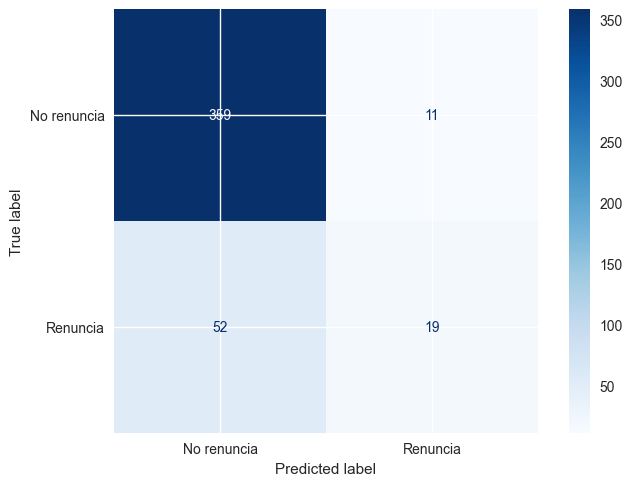

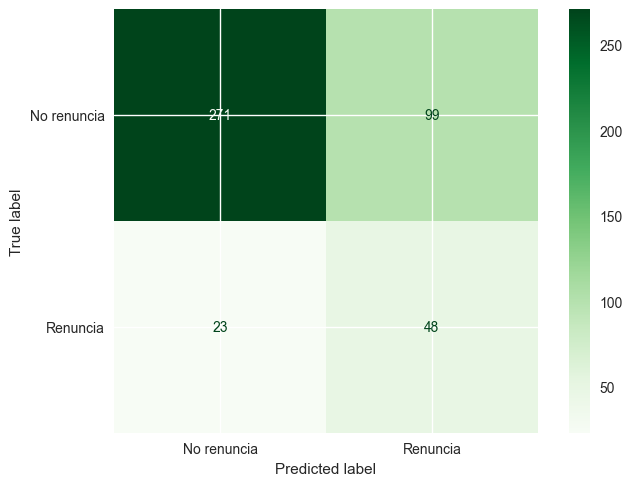

In [50]:
print("=== Modelo sin balancear ===")
print(classification_report(y_test, y_pred_lg_unbalanced))
cm_lg_unbalanced = confusion_matrix(y_test, y_pred_lg_unbalanced)
ConfusionMatrixDisplay(cm_lg_unbalanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Blues')

print("\n=== Modelo balanceado ===")
print(classification_report(y_test, y_pred_lg_balanced))
cm_lg_balanced = confusion_matrix(y_test, y_pred_lg_balanced)
ConfusionMatrixDisplay(cm_lg_balanced, display_labels=['No renuncia', 'Renuncia']).plot(cmap='Greens')

### Coeficientes de la Regresión Logística
La **Regresión Logística** no puede visualizarse mediante una estructura jerárquica, ya que es un modelo lineal.  
En su lugar, se analizan los **coeficientes del modelo**, que representan el efecto de cada variable sobre la probabilidad de renuncia de empleados (*Attrition*).

- Los **coeficientes positivos** indican que la variable **aumenta la probabilidad de renuncia**.  
- Los **coeficientes negativos** indican que la variable **disminuye la probabilidad de renuncia**.  
- La **magnitud del coeficiente** refleja el peso relativo de esa variable en la decisión del modelo.

A continuación, se muestran las variables con los coeficientes más altos y más bajos del modelo balanceado, para identificar los factores que influyen de forma positiva o negativa en la renuncia.

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\310938114.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variable', data=coef_df.head(10), palette='Set2')


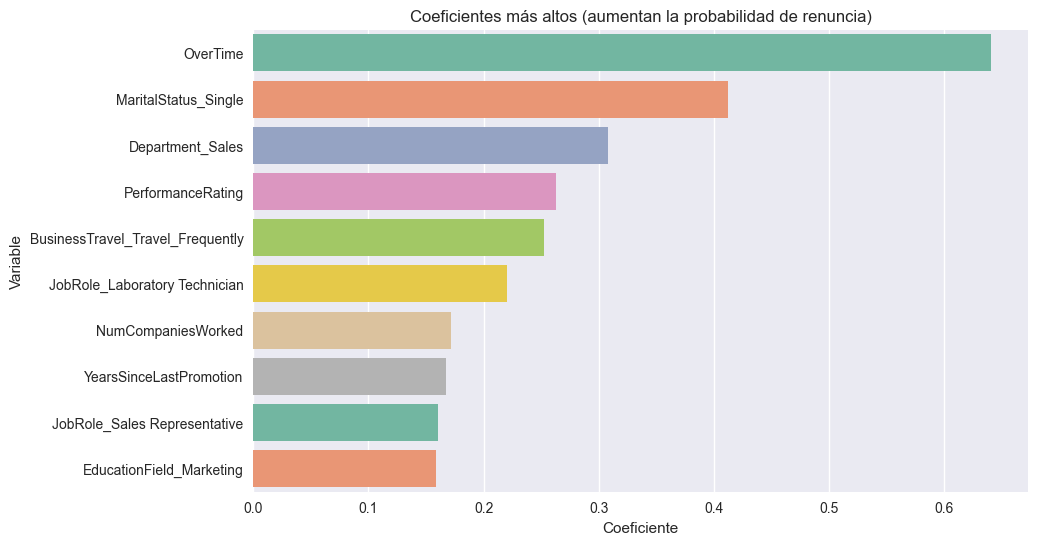

C:\Users\elias\AppData\Local\Temp\ipykernel_22276\310938114.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coeficiente', y='Variable', data=coef_df.tail(10), palette='Set2')


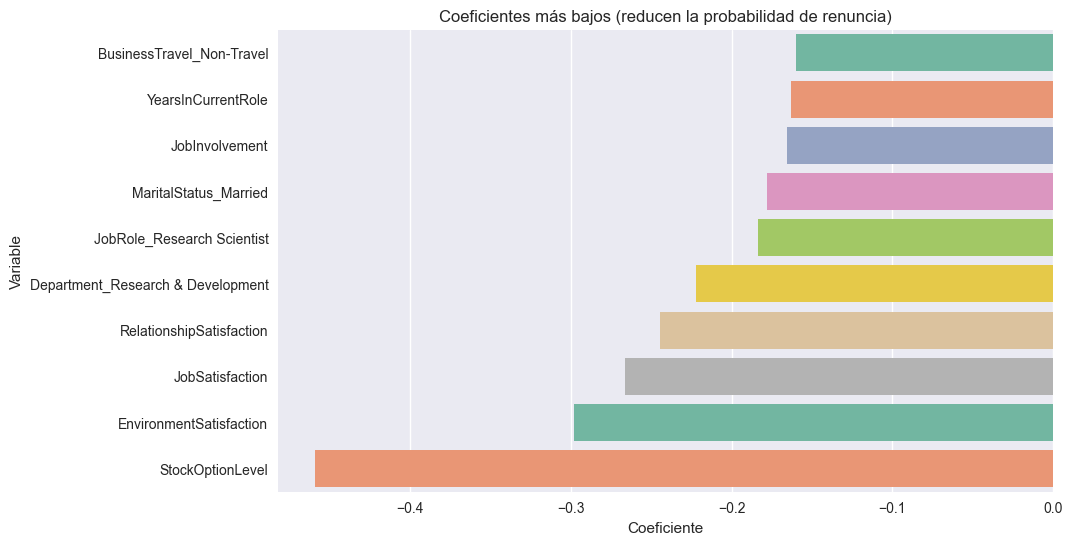

In [52]:
# Se analizan los coeficientes del modelo balanceado para identificar
# qué variables influyen positiva o negativamente en la probabilidad de renuncia.
coef = model_lg_balanced.coef_[0]
features = X.columns

coef_df = pd.DataFrame({'Variable': features, 'Coeficiente': coef})
coef_df = coef_df.sort_values(by='Coeficiente', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Variable', data=coef_df.head(10), palette='Set2')
plt.title("Coeficientes más altos (aumentan la probabilidad de renuncia)")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Coeficiente', y='Variable', data=coef_df.tail(10), palette='Set2')
plt.title("Coeficientes más bajos (reducen la probabilidad de renuncia)")
plt.show()

### 📊 Interpretación del modelo de Regresión Logística

La **Regresión Logística (Logistic Regression)** alcanza un **rendimiento general sólido**, con una *accuracy* de **86 %** en el modelo sin balancear y **72 %** en la versión balanceada.  
Su principal fortaleza radica en la interpretabilidad y en su capacidad para estimar probabilidades de renuncia de manera directa.

- En el **modelo sin balancear**, la precisión general es alta (0.86) gracias al excelente desempeño sobre la clase **0 (No renuncia)**, con *recall* ≈ 0.97.  
  Sin embargo, el modelo subestima la clase **1 (Renuncia)**, con un *recall* bajo (≈ 0.27), lo que refleja la misma limitación observada en los modelos basados en árboles.  
- En el **modelo balanceado**, el *recall* de la clase **1 (Renuncia)** mejora significativamente (de 0.27 → 0.68), aunque a costa de una reducción en la *accuracy* total (de 0.86 → 0.72) y en la precisión para la clase mayoritaria.  

En síntesis, la regresión logística **sacrifica algo de precisión global para ganar sensibilidad**, ofreciendo una mejor capacidad para detectar casos de renuncia, aunque con mayor cantidad de falsos positivos.

---

### 🔍 Análisis de variables más relevantes

El análisis de **coeficientes** muestra de forma clara qué factores influyen positiva o negativamente en la probabilidad de renuncia:

- Las variables con **coeficientes positivos** —como **OverTime**, **MaritalStatus_Single**, **Department_Sales** y **PerformanceRating**— **aumentan la probabilidad de renuncia**, asociándose con mayor carga laboral, estado civil soltero o áreas de trabajo más dinámicas.  
- En cambio, las variables con **coeficientes negativos**, como **StockOptionLevel**, **EnvironmentSatisfaction**, **JobSatisfaction** y **RelationshipSatisfaction**, **reducen la probabilidad de renuncia**, reflejando la influencia de la satisfacción laboral, el entorno y los incentivos en la retención del empleado.  

Estos resultados permiten identificar los **factores más determinantes en la decisión de renuncia**, destacando el impacto del entorno laboral, la carga de trabajo y el reconocimiento económico.

---

**Conclusión:**  
La **Regresión Logística** logra un equilibrio más claro entre **precisión e interpretabilidad**, mejorando la detección de las renuncias en su versión balanceada.  
Aunque su rendimiento global es ligeramente inferior al del Bosque Aleatorio, **aporta una visión más transparente sobre los factores que explican la rotación laboral**, consolidándose como un modelo de referencia para la interpretación del fenómeno de renuncia en el conjunto de empleados.

# 5. Conclusiones generales

El análisis comparativo entre los tres modelos de clasificación —**Árbol de Decisión**, **Bosque Aleatorio** y **Regresión Logística**— permitió evaluar distintas estrategias para predecir la renuncia de empleados (*Attrition*).

- El **Árbol de Decisión** ofreció una interpretación clara pero limitada capacidad predictiva sobre la clase minoritaria.  
- El **Bosque Aleatorio** mejoró la precisión y estabilidad general, aunque mantuvo baja sensibilidad frente a las renuncias.  
- La **Regresión Logística**, especialmente en su versión balanceada, logró un mejor equilibrio entre precisión e interpretabilidad, incrementando el *recall* de la clase minoritaria.

En conjunto, los resultados evidencian que el **desbalance de clases** sigue siendo un desafío central, y que la combinación de **modelos explicativos y técnicas de balanceo** constituye una estrategia efectiva para comprender y anticipar la rotación laboral.

Este proyecto demuestra la aplicación del **flujo completo de Machine Learning supervisado**, desde la exploración de datos hasta la evaluación e interpretación de modelos, con criterios reproducibles y orientados a la toma de decisiones.